In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lal
from lalsimulation.nrfits.NRSur7dq4Remnant import NRSur7dq4Remnant
from gwtools import rotations   
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions

import os
os.environ["LAL_DATA_PATH"] = os.path.join(os.environ['HOME'], 'lalsuite-extra/data/lalsimulation')

lal.MSUN_SI != Msun


/Users/smiller/anaconda3/lib/python3.10/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")


Define surrogate

In [2]:
sur = NRSur7dq4Remnant()
sur_dyn = sur._get_surrogate_dynamics

Define functions

In [3]:
def calc_incl_vs_time(f_ref, M, q, chiA0, chiB0, incl, phi_ref):   
    
    assert q>=1, 'q must be >=1'
    
    # freq to omega
    omega_ref = -1 if f_ref==-1 else f_ref * np.pi* M * lal.MTSUN_SI

    # Get surrogate dynamics
    dyn_times, quat_sur, orbphase_sur, chiA_copr_sur, chiB_copr_sur \
        = sur_dyn(q, chiA0, chiB0, [1,0,0,0], 0, omega_ref, False)

    # Direction of the orbital angular momentum, defined with respect to the
    # source frame at f_ref
    Lhat = rotations.lHat_from_quat(quat_sur).T

    # N_hat = the direction of the line of sight from source to obsever,
    # also defined with respect to the source frame at f_ref
    phi = np.pi/2 - phi_ref
    Nhat = np.array([np.sin(incl)*np.cos(phi), \
                      np.sin(incl)*np.sin(phi), \
                      np.cos(incl)]).T

    # Take inner product of the two unit vector and arccos it to get
    # inclination as a function of time.
    incl_vs_t = np.arccos(np.sum(Lhat * Nhat, axis=1))
    
    return dyn_times, incl_vs_t

In [4]:
def m1m2_from_mtotq(mtot, q):
    m1 = mtot / (1 + q)
    m2 = mtot - m1
    return m1, m2

Define parameters for test cases

In [5]:
freq = 20      # You may want to use -1, but with the my lalsuite branch
M = 60          # Detector frame total mass
q = 1.1

chiA0_noprec = [0, 0, 0.5]
chiB0_noprec = [0, 0, 0.5]

chiA0_prec = [-0.3, -0.5, 0.1]
chiB0_prec = [0.3, 0.4, 0.1]

incl = np.pi/2 + 0.01          # This is what bilby might call iota/inclination

phi_ref = 0.3       # This is what bilby calls phase

Calculate the inclination vs time

In [6]:
times_noprec, incl_v_times_noprec = calc_incl_vs_time(freq, M, q, chiA0_noprec, chiA0_noprec, incl, phi_ref)
times_prec, incl_v_times_prec = calc_incl_vs_time(freq, M, q, chiA0_prec, chiA0_prec, incl, phi_ref)
times_prec2, incl_v_times_prec2 = calc_incl_vs_time(freq, 100, q, chiA0_prec, chiA0_prec, incl, phi_ref)

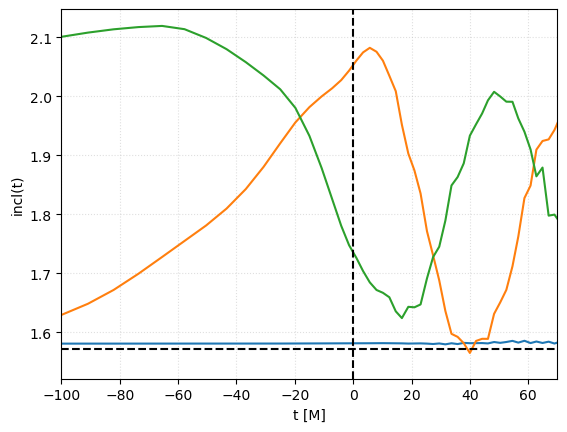

In [7]:
plt.figure()

plt.plot(times_noprec, incl_v_times_noprec)
plt.plot(times_prec, incl_v_times_prec)
plt.plot(times_prec2, incl_v_times_prec2)

plt.xlabel('t [M]')
plt.ylabel('incl(t)')

plt.xlim(-100, 70)
plt.axvline(0, color='k', ls='--')
plt.grid(color='silver', alpha=0.5, ls=':')

plt.axhline(np.pi/2, color='k', ls='--')

plt.show()

Load in emcee posterior and repeat with draws from it

In [8]:
# Load reconstructions
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 
reconstruction_fname = "waveform_reconstructions_L1.npy"
reconstruction_dict = np.load(data_dir+reconstruction_fname,allow_pickle=True).item()

In [9]:
# Get parameters for them 
waveform_parameters = reconstruction_dict['full']['params']

In [10]:
# Downsample
nsamples = 1000
waveform_parameters_to_plot = np.random.choice(waveform_parameters, size=nsamples)

In [12]:
incl_vs_time_dict = {}

for f in [11, 20, 30]: 
    
    print(f'f_ref = {f} Hz')

    # Array in which to store data 
    times = []
    incl_v_times = []

    # Cycle through samples 
    for i, samp in enumerate(waveform_parameters_to_plot):

        print(i+1, end='\r')

        M = samp['mtotal'] # Detector frame total mass
        q = samp['q']
        m1, m2 = m1m2_from_mtotq(M, q) # Detector frame component masses
        eta=m1*m2/(m1+m2)/(m1+m2) # Symmetric mass ratio
        m1_SI = m1*lal.MSUN_SI    # Convert to kg
        m2_SI = m2*lal.MSUN_SI
        chi1 = samp['chi1']
        chi2 = samp['chi2']
        tilt1 = samp['tilt1']
        tilt2 = samp['tilt2']
        phi12 = samp['phi12']
        theta_jn = samp['theta_jn']
        phi_jl = samp['phi_jl']
        dist_mpc = samp['dist']
        phi_ref = samp['phase']

        # Transform spin convention 
        incl, s1x, s1y, s1z, s2x, s2y, s2z = SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt1, tilt2, phi12, chi1, chi2, m1_SI, m2_SI, f, phi_ref
        )

        # Translate between LIGO and NR conventions 
        q_sur = 1.0/q           # q = m1/m2 in NR <-> q = m2/m1 in LIGO
        chiA0 = [s1x, s1y, s1z] # subscript "A" in NR <-> subscript "1" in LIGO
        chiB0 = [s2x, s2y, s2z] # subscript "B" in NR <-> subscript "2" in LIGO

        # Calculate incl vs time
        t, incl_v_t = calc_incl_vs_time(f, M, q_sur, chiA0, chiB0, incl, phi_ref)

        times.append(t)
        incl_v_times.append(incl_v_t)
                
    incl_vs_time_dict[f'fref {int(f)}'] = {'times':times, 'incl_v_time':incl_v_times}
    
    print('\n')

f_ref = 11 Hz
1000
f_ref = 20 Hz
1000
f_ref = 30 Hz
1000


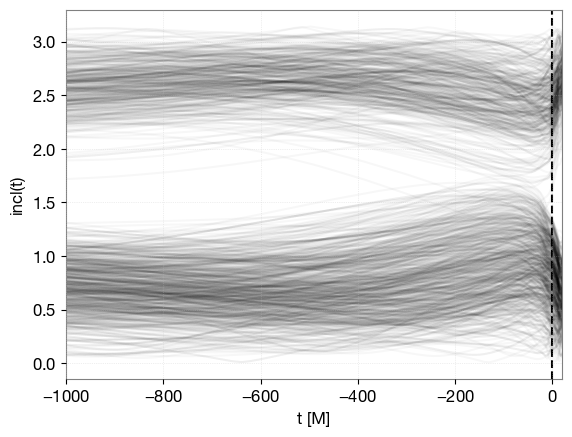

In [13]:
plt.figure()

for i in range(nsamples):
    plt.plot(incl_vs_time_dict['fref 11']['times'][i], 
             incl_vs_time_dict['fref 11']['incl_v_time'][i], color='k', alpha=0.03)

plt.xlabel('t [M]')
plt.ylabel('incl(t)')

plt.xlim(-1000, 20)
plt.axvline(0, color='k', ls='--')
plt.grid(color='silver', alpha=0.5, ls=':')

plt.show()

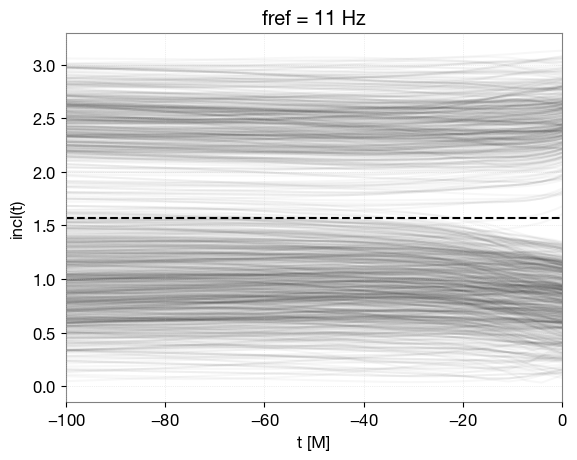

In [16]:
# Zoom in 
plt.figure()

for i in range(nsamples):
    plt.plot(incl_vs_time_dict['fref 11']['times'][i], 
             incl_vs_time_dict['fref 11']['incl_v_time'][i], color='k', alpha=0.03)

plt.xlabel('t [M]')
plt.ylabel('incl(t)')
plt.axhline(np.pi/2, color='k', ls='--')

plt.xlim(-100, 0)
plt.grid(color='silver', alpha=0.5, ls=':')
plt.title('fref = 11 Hz')

plt.show()

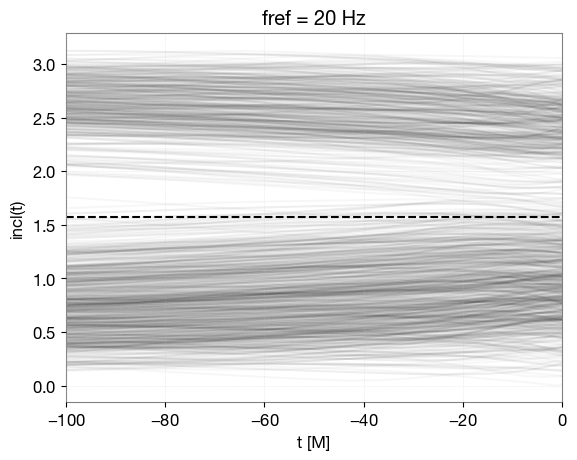

In [17]:
# Zoom in 
plt.figure()

for i in range(nsamples):
    plt.plot(incl_vs_time_dict['fref 20']['times'][i], 
             incl_vs_time_dict['fref 20']['incl_v_time'][i], color='k', alpha=0.03)

plt.xlabel('t [M]')
plt.ylabel('incl(t)')
plt.axhline(np.pi/2, color='k', ls='--')

plt.xlim(-100, 0)
plt.grid(color='silver', alpha=0.5, ls=':')
plt.title('fref = 20 Hz')

plt.show()